# Analysis

In [2]:
from RandmanFunctions import get_randman_dataset
from Utilities import spike_to_label, voltage_to_logits

import wandb
import snntorch as snn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = 'cuda'

In [8]:
class SNN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, learn_beta, beta=0.95):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden, bias=False)
        self.lif1 = snn.Leaky(beta=beta, learn_beta=learn_beta)

        self.fc2 = nn.Linear(num_hidden, num_outputs, bias=False)
        self.lif2 = snn.Leaky(beta=beta, learn_beta=learn_beta, reset_mechanism='none')

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # nn.init.zeros_(m.bias)

    def forward(self, x):
        # import pdb; pdb.set_trace()
        batch_size, time_steps, num_neurons = x.shape
        x = x.permute(1, 0, 2)  # (time, batch, neurons)

        mem1, mem2 = [torch.zeros(batch_size, layer.out_features, device=x.device)
                      for layer in [self.fc1, self.fc2]]

        mem2_rec = []

        for t in range(time_steps):
            spk1, mem1 = self.lif1(self.fc1(x[t]), mem1)
            _, mem2 = self.lif2(self.fc2(spk1), mem2)
            mem2_rec.append(mem2)

        return torch.stack(mem2_rec, dim=0)  # (time_steps, batch_size, num_outputs)
    
def losscustom(pred, labels):
  # batch, classes, time_steps
  # import pdb; pdb.set_trace()
  mem = pred.permute(1,2,0)
  labels = labels.long()
  non_labels = 1-labels

  batch_idx = torch.arange(mem.shape[0])

  correct = mem[batch_idx, labels]
  non_correct = mem[batch_idx, non_labels]

  diff = non_correct - correct
  diff_activated = torch.where(diff > 0, diff, torch.zeros_like(diff))
  return (diff_activated).mean()


## Output Layer Voltage

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_theme()

def plot_output_layer_voltages(snn, x, label):
    """plot voltage trace of the output layer of snn

    Args:
        snn (nn.Module): the model
        x (tensor): of shape [batch=1, time steps, nb_inputs]
    """
    mem_out = snn(x) # mem_out shape: [time steps, batch=1, classes]
    pred_label = spike_to_label(mem_out, scheme = 'highest_voltage')
    mem_out = mem_out.cpu().detach().numpy().squeeze(axis=1)
    
    df = pd.DataFrame(mem_out, columns = ['mem-0', 'mem-1'])
    
    # plotting
    sns.lineplot(df)
    plt.title(f'Class Label: {label.item()}, Model Pred:{pred_label.item()}')
    plt.xlabel('time step')
    plt.ylabel('voltage')
    plt.show()

def _test_plot_layer_voltages():
    snn = SNN(10, 20, 2, False)
    x = torch.rand([1, 100, 10]) # [batch, time steps, neurons]
    plot_output_layer_voltages(snn, x, 0)
    
# _test_plot_layer_voltages()
    

## Hidden Layer Spike Train

In [5]:
def spike_train_to_events(spike_train):
    # spike_train shape: [time_steps, neurons]
    # output shape: [events, 2]. ([time step, neuron] pairs)
    
    non_zeros_indicies = np.nonzero(spike_train) # nonzeros: ([...dim 1 indicies for nonzero....], [...dim 2 indicies...])
    return np.stack(non_zeros_indicies).T

def plot_hidden_layer_spike_raster(snn, x):
    spikes = []
    def hook(module, input, output):
        spikes.append(output[0][0].detach().numpy()) # first 0 index the output, the second index the batch dimension
    
    handle = snn.lif1.register_forward_hook(hook)
    snn(x)
    handle.remove()
    
    spikes = np.stack(spikes)
    events = spike_train_to_events(spikes)
    df = pd.DataFrame(events, columns=['time step', 'neuron'])
    
    # plotting
    sns.scatterplot(df, x = 'time step', y = 'neuron')
    plt.legend([],[], frameon=False) # no labels
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # plot intergers only
    plt.xlabel('time step')
    plt.ylabel('neurons')
    plt.show()
    
def _test_plot_hidden_layer_spikes():
    # setup
    model = SNN(3,50,2, False)   
    x = torch.randn([1, 100, 3]) # [batch=1, time_steps, neurons]
    plot_hidden_layer_spike_raster(model, x)
    
# _test_plot_hidden_layer_spikes()

## Logits Difference

In [6]:
def plot_logits_difference_distribution(model, dataset):
    val_loader = DataLoader(dataset, batch_size=256)
    logits = []
    for batch, (x, y) in enumerate(val_loader):
        mem_out = model(x)
        logits.append(voltage_to_logits(mem_out).detach().numpy())
        
    logits = np.concatenate(logits, axis = 0) # logits shape [nb_samples, 2]
    diff = np.expand_dims((logits[:, 0] - logits[:, 1]), axis = -1)
    df = pd.DataFrame(diff, columns=['diff'])
    
    sns.histplot(df)
    plt.xlabel('logit_0 - logit_1')
    plt.title('Logits Difference Distribution')
    plt.show()
    

## Plot

In [18]:
def get_run_and_model(run_id, model_idx):
    ENTITY = 'DarwinNeuron'
    PROJECT = 'DarwinNeuron'

    # obtain run for hyperparameter records
    api = wandb.Api()
    run = api.run(f'{ENTITY}/{PROJECT}/{run_id}')
    
    # download 
    artifact = run.logged_artifacts()[model_idx]
    model_path = artifact.download() 
    
    # load model
    model = SNN(run.config['nb_input'], run.config['nb_hidden'], run.config['nb_output'], run.config['learn_beta'])
    model.load_state_dict(torch.load(f'{model_path}/best-model.pth', weights_only = True))
    
    return run, model

# run_id = 'wvoaejgq' # cross-entropy-no-weight
# run_id = 'xlqvzaqr' # diff-sigmoid-reg
# run_id = '7ktqsno0' # cross-entropy
run, model = get_run_and_model('wvoaejgq', 435)

wandb:   1 of 1 files downloaded.  


(diff-sigmoid-reg, model-4, sample-14) Why membrane decay at diff rate? Why at different initail value? 


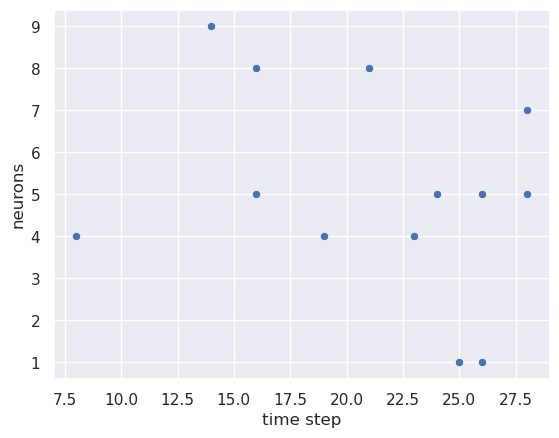

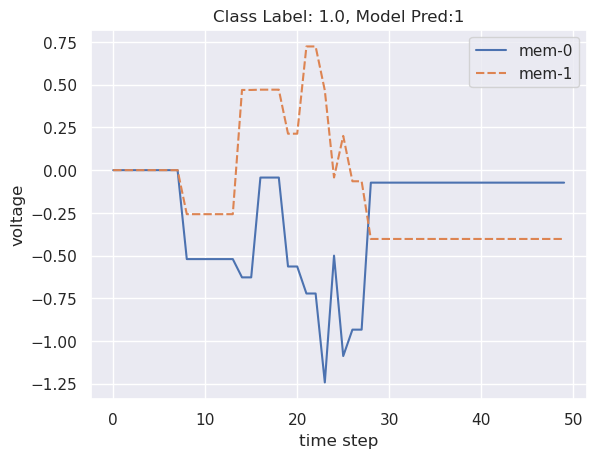

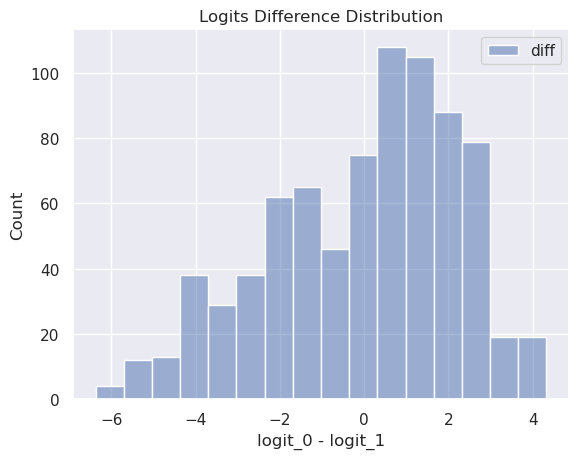

In [10]:
from sklearn.model_selection import train_test_split
def plot_main(run, model):
    # prepare dataset
    train_dataset, val_dataset = train_test_split(get_randman_dataset(run.config['nb_output'], run.config['nb_input'], run.config['nb_steps'], run.config['nb_data_samples']), test_size=0.2, shuffle=False)

    sample_idx = 14
    x = val_dataset[sample_idx][0].unsqueeze(axis=0) # unsqueeze to insert batch dimension
    y = val_dataset[sample_idx][1].unsqueeze(axis=0)
    
    plot_hidden_layer_spike_raster(model, x)
    plot_output_layer_voltages(model, x, y)
    plot_logits_difference_distribution(model, val_dataset)

    
plot_main(run, model)

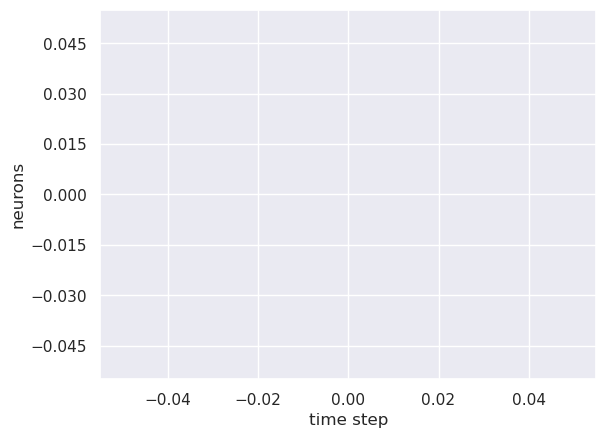

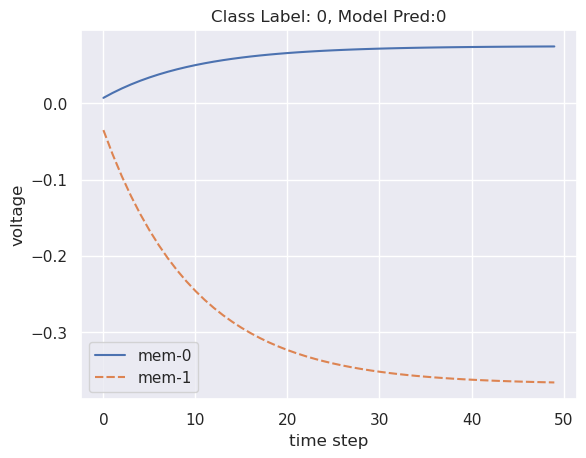

In [54]:
def plot_idle_model(model):
    x = torch.zeros([1, 50, 100])
    plot_hidden_layer_spike_raster(model, x)
    plot_output_layer_voltages(model, x, label=torch.tensor([0,]))
plot_idle_model(model)

## Parameter Distribution

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


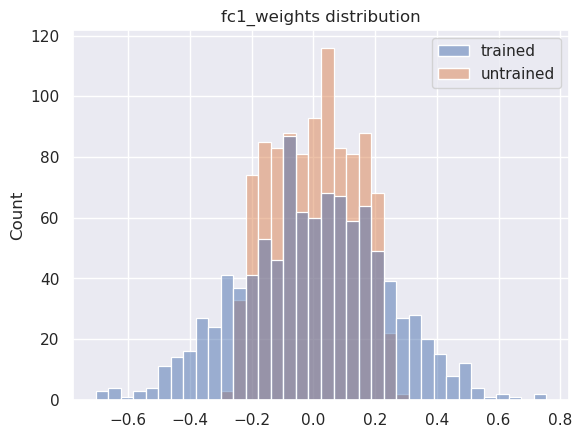

In [ ]:
def plot_param_distribution(model):    
    _, trained_model = get_run_and_model('wvoaejgq', 435)
    _, untrained_model = get_run_and_model('wvoaejgq', 5)
    
    fc1_weights = []
    for model in (trained_model, untrained_model):
        param_dict = dict(model.named_parameters())
        fc1_weights.append(param_dict['fc1.weight'].detach().numpy().reshape([-1,]))
    fc1_weights = np.stack(fc1_weights, axis = 0).T
    
    df = pd.DataFrame(fc1_weights, columns=['trained', 'untrained'])
    sns.histplot(df)
    plt.title('fc1_weights distribution')
    
plot_param_distribution(model)